# ИУ5-62Б Никитина К.В.

## Рубежный контроль №2

### Задача
Для заданного набора данных (по Вашему варианту) постройте модели классификации или регрессии (в зависимости от конкретной задачи, рассматриваемой в наборе данных). Для построения моделей используйте методы 1 и 2 (по варианту для Вашей группы). Оцените качество моделей на основе подходящих метрик качества (не менее двух метрик). Какие метрики качества Вы использовали и почему? Какие выводы Вы можете сделать о качестве построенных моделей? Для построения моделей необходимо выполнить требуемую предобработку данных: заполнение пропусков, кодирование категориальных признаков, и т.д.

### Набор данных
https://www.kaggle.com/rhuebner/human-resources-data-set

### Методы
* метод опорных векторов
* случайный лес

## Решение

In [58]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [ ]:
data = pd.read_csv("HRDataset_v14.csv")
data.head()

In [ ]:
data.info()

In [ ]:
print('Количество пропущенных значений')
data.isnull().sum()

Удалим строки с пропущенными значениями, которые не влияют на целевой признак.

In [ ]:
data = data.dropna(subset=['DateofTermination'], axis=0)
data = data.dropna(subset=['Termd'], axis=0)
del data['ManagerName']
del data['RecruitmentSource']
del data['PerformanceScore']

In [ ]:
not_number_cols = data.select_dtypes(include=['object'])
number_cols = data.select_dtypes(exclude=['object'])

le = preprocessing.LabelEncoder()

for col_name in not_number_cols:
    data[col_name] = le.fit_transform(data[col_name])

In [ ]:
data

### Выбор метрик и подготовка данных

Так как выполняется задача небинарной классификации и в тестовой выборке возможен дисбаланс классов, были выбраны следующие метрики:

* precision;
* recall;
* f1-score.

Всем метрикам был задан уровень детализации average='weighted'.

In [ ]:
def print_metrics(y_test, y_pred):
    rep = classification_report(y_test, y_pred, output_dict=True)
    print("weighted precision:", rep['weighted avg']['precision'])
    print("weighted recall:", rep['weighted avg']['recall'])
    print("weighted f1-score:", rep['weighted avg']['f1-score'])
    plt.figure(figsize=(4, 3))
    plt.title('Матрица ошибок')
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues");

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(['GenderID'], axis=1), data['GenderID'], test_size=0.5, random_state=17)

### SVC. Базовая модель.

In [ ]:
scaler = StandardScaler().fit(x_train)
x_train_scaled = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns=x_train.columns)
x_train_scaled.describe()

In [ ]:
svm_model = SVC()
svm_model.fit(x_train_scaled, y_train)
y_pred_svm = svm_model.predict(x_test_scaled)
print_metrics(y_test, y_pred_svm)

### Подбор гиперпараметров

In [ ]:
params = {'C': np.concatenate([np.arange(0.1, 2, 0.03), np.arange(2, 20, 1)])}
grid_cv = GridSearchCV(estimator=svm_model, param_grid=params, cv=10, n_jobs=-1, scoring='f1_macro')
grid_cv.fit(x_train_scaled, y_train)
print(grid_cv.best_params_)

Лучшая модель

In [ ]:
best_svm_model = grid_cv.best_estimator_
best_svm_model.fit(x_train_scaled, y_train)
y_pred_svm = best_svm_model.predict(x_test_scaled)
print_metrics(y_test, y_pred_svm)

### RandomForestClassifier

Базовая модель

In [ ]:
rfc_model = RandomForestClassifier()
rfc_model.fit(x_train, y_train)
y_pred_rfc = rfc_model.predict(x_test)
print_metrics(y_test, y_pred_rfc)

Подбор гиперпараметров

In [ ]:
params = {'n_estimators': [5, 10, 50, 100], 'max_features': [2, 3, 4], 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 2, 3, 4, 5]}
grid_cv = GridSearchCV(estimator=rfc_model, param_grid=params, cv=10, n_jobs=-1, scoring='f1_weighted')
grid_cv.fit(x_train, y_train)
print(grid_cv.best_params_)

Лучшая модель

weighted precision: 1.0
weighted recall: 1.0
weighted f1-score: 1.0


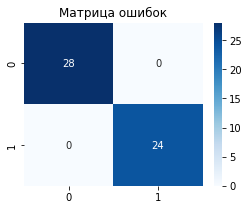

In [93]:
best_rfc_model = grid_cv.best_estimator_
best_rfc_model.fit(x_train, y_train)
y_pred_rfc = best_rfc_model.predict(x_test)
print_metrics(y_test, y_pred_rfc)

Сравнение результатов

SVC result

weighted precision: 0.9427978318533042
weighted recall: 0.9423076923076923
weighted f1-score: 0.9422000172280126


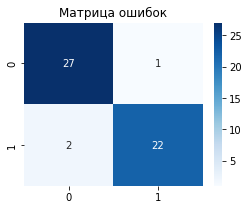

In [94]:
print("SVC result\n")
print_metrics(y_test, y_pred_svm)

RandomForestClassifier result

weighted precision: 1.0
weighted recall: 1.0
weighted f1-score: 1.0


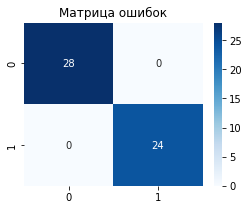

In [95]:
print("RandomForestClassifier result\n")
print_metrics(y_test, y_pred_rfc)

Вывод

Модели с подобранными гиперпараметрами оказались лучше базовых моделей. Обе конечные модели показали очень высокую точность прогноза, что объясняется спецификой используемого "игрушечного" датасета. Из матриц ошибок видим, что обе модели совершили по 2 неверных прогноза из 75, однако ошибки у них разные. Метрики показывают, что качества рассматриваемых моделей практически одинаковое: отличия начинаются лишь в 4 знаке после запятой.